In [1]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random
import sys
import pickle
import os
from scipy.io import loadmat
# Load the MNIST digit data
M = loadmat("mnist_all.mat")

In [2]:
def softmax(y):
    '''Return the output of the softmax function for the matrix of output y. y
    is an NxM matrix where N is the number of outputs for a single case, and M
    is the number of cases'''
    return exp(y) / tile(sum(exp(y), 0), (len(y), 1))

In [3]:
def tanh_layer(y, W, b):
    '''Return the output of a tanh layer for the input matrix y. y
    is an NxM matrix where N is the number of inputs for a single case, and M
    is the number of cases'''
    return tanh(dot(W.T, y) + b)

In [4]:
def forward(x, W0, b0, W1, b1):
    L0 = tanh_layer(x, W0, b0)
    L1 = dot(W1.T, L0) + b1
    output = softmax(L1)
    return L0, L1, output

In [5]:
def cost_function(y, p):
    return -np.sum(y * np.log(p))

In [6]:
def get_data(M):
    train_keys = [key for key in M.keys() if "train" in key]
    data_length = 0
    for train_k in train_keys:
        data_length += M[train_k].shape[0]

    # concatenate all the data
    train_data = np.zeros((data_length, 784))
    data_counter = 0
    data_size = 0

    train_y = np.zeros((data_length, 10))
    for i, train_k in enumerate(train_keys):
        data_size = M[train_k].shape[0]
        #print(i, data_size)
        train_data[data_counter: data_counter + data_size, :] = M[train_k]
        train_y[data_counter: data_counter + data_size, i] = 1
        data_counter += data_size
    return train_data, train_y

#plot learning curves
#collect testing data
def get_test_data(M):
    train_keys = [key for key in M.keys() if "test" in key]
    data_length = 0
    for train_k in train_keys:
        data_length += M[train_k].shape[0]

    # concatenate all the data
    train_data = np.zeros((data_length, 784))
    print(data_length)
    data_counter = 0
    data_size = 0

    train_y = np.zeros((data_length, 10))
    for i, train_k in enumerate(train_keys):
        data_size = M[train_k].shape[0]
        #print(i, data_size)
        train_data[data_counter: data_counter + data_size, :] = M[train_k]
        train_y[data_counter: data_counter + data_size, i] = 1
        data_counter += data_size
    return train_data, train_y

In [7]:
def part2(x, W0, b0):
    total_W0 = np.concatenate((b0, W0))
    added_ones = np.ones(x.shape[1]).reshape(x.shape[1], 1)
    total_x = np.concatenate((added_ones.T, x))
    vals = softmax(np.dot(total_W0.T, total_x))
    return vals.T

def part3(x, y1, p):
    deriv = np.subtract(p, y1)
    added_ones = np.ones(x.shape[1]).reshape(x.shape[1], 1)
    total_x = np.concatenate((added_ones.T, x))
    deriv = np.matmul(deriv.T, total_x.T).T
    return deriv  # shape 10, 785

In [8]:
def df(x, W0, y):
    # this W0 is assumed to have the bias incorperated into it
    #print(W0.shape, y.shape)
    W1, b0 = W0[:-1, :].reshape(784, W0.shape[1]), W0[-1, :].reshape(1, 10)
    vals = part2(x, W1, b0)
    return part3(x, y, vals)

In [9]:
# PART ONE DATA SNIPPIT
# Load sample weights for the multilayer neural network
snapshot = pickle.load(open("snapshot50.pkl", "rb"), encoding="latin-1")
W0 = snapshot["W0"]  # data
b0 = snapshot["b0"].reshape((300, 1))  # bias?
W1 = snapshot["W1"]  # should be likelihoods?
b1 = snapshot["b1"].reshape((10, 1))  # classes?
#print(W0.shape)

np.random.seed(0)
weights = np.random.random(size=784*10).reshape((784, 10))/10.
weights_bias = np.zeros(10).reshape(1, 10)
#np.random.random(size=10).reshape((1, 10))



In [11]:
def momemtum_grad_descent_learning_curves(df, x, y, W0, b0, alpha, testX, testY, momemtum = 0.9, EPS=1e-7):
    # EPS = 1e-5   #EPS = 10**(-5)
    start = time.time()
    total_W0 = np.concatenate((b0, W0))
    prev_totalW0 = total_W0 - 10 * EPS
    W1 = total_W0.copy()
    # inital weights, pass in both bias and weights together for now
    max_iter = 6500
    iter = 0
    performance_test = np.zeros(max_iter//100) #check performance every 100 iterations
    performance_train = np.zeros_like(performance_test)

    added_ones = np.ones((testX.shape[1], 1))
    totaltestX = np.concatenate((testX.T,added_ones), axis=1)
    
    added_ones = np.ones((x.shape[1], 1))
    totaltrainX = np.concatenate((x.T, added_ones), axis = 1)
    
    counter = 0
    new_momentum = 1
    while norm(W1 - prev_totalW0) > EPS and iter < max_iter:
        prev_totalW0 = W1.copy()
        new_momentum = momemtum*new_momentum + df(x, W1, y)
        W1 -= new_momentum
        if iter % 100 == 99:
            print("Iter", iter)
            preds = np.matmul(totaltrainX, W1)
            preds_max =  preds.max(axis = 1)
            final_preds = np.isin(preds, preds_max).astype(int)
            #how many of the hot keys match for validation
            performance_train[counter] =  len(np.where((trainY == final_preds).all(axis =1)==True)[0])/60000.
            
            preds = np.matmul(totaltestX, W1)
            preds_max =  preds.max(axis = 1)
            final_preds = np.isin(preds, preds_max).astype(int)
            #how many of the hot keys match for validation
            performance_test[counter] = len(np.where((testY == final_preds).all(axis =1)==True)[0])  /10000.
            
            #counter +=1
            print(performance_train[counter], performance_test[counter])
            counter +=1
        iter += 1
        
    print("Iter", iter)
    end = time.time()
    print("Time taken:", (end - start))
    return W1, performance_train, performance_test


def part5(data, W0, b0, y, testX, testY):
    np.random.seed(0)
    alpha = 0.01
    final_weights, momt_train, momt_test = momemtum_grad_descent_learning_curves(df, data, y, W0, b0, alpha, testX, testY, 0.9,EPS=1e-4)
    return final_weights, momt_train, momt_test


In [15]:
##PART FOUR##
trainX, trainY = get_data(M)
print(np.where(trainX==np.nan))
trainX = trainX.T/255. /255.
print("TrainX", trainX.shape)

testX, testY = get_test_data(M)
testX = np.nan_to_num(testX)
testX = testX.T/255./255.
print("TestX", testX.shape)

#final_weights = part5(trainX, weights, weights_bias, trainY, testX, testY)

(array([], dtype=int64), array([], dtype=int64))
TrainX (784, 60000)
10000
TestX (784, 10000)


Plot the learning curves with these set of parameters every 400 iterations, see how the performance changes

In [16]:
final_weights, performance_train, performance_test = part5(trainX, weights, weights_bias, trainY, testX, testY)

Iter 99
0.892483333333 0.8926
Iter 199
0.90175 0.9034
Iter 299
0.900216666667 0.8988
Iter 399
0.894283333333 0.8906
Iter 499
0.88865 0.8923
Iter 599
0.880716666667 0.8848
Iter 699
0.875983333333 0.8795
Iter 799
0.871683333333 0.8776
Iter 899
0.868633333333 0.8733
Iter 999
0.868033333333 0.8722
Iter 1099
0.867766666667 0.8713
Iter 1199
0.867316666667 0.8697
Iter 1299
0.866316666667 0.8683
Iter 1399
0.866633333333 0.8666
Iter 1499
0.8666 0.8657
Iter 1599
0.866166666667 0.8612
Iter 1699
0.86485 0.8632
Iter 1799
0.86455 0.8604
Iter 1899
0.86425 0.8605
Iter 1999
0.86375 0.8602
Iter 2099
0.8635 0.8589
Iter 2199
0.863983333333 0.8595
Iter 2299
0.864483333333 0.856
Iter 2399
0.864533333333 0.8577
Iter 2499
0.863783333333 0.8578
Iter 2599
0.862933333333 0.8589
Iter 2699
0.862733333333 0.8588
Iter 2799
0.862366666667 0.8604
Iter 2899
0.862416666667 0.86
Iter 2999
0.862283333333 0.8604
Iter 3099
0.862616666667 0.862
Iter 3199
0.862233333333 0.8618
Iter 3299
0.861983333333 0.8622
Iter 3399
0.86175

In [17]:
performance_train, performance_test

(array([ 0.89248333,  0.90175   ,  0.90021667,  0.89428333,  0.88865   ,
         0.88071667,  0.87598333,  0.87168333,  0.86863333,  0.86803333,
         0.86776667,  0.86731667,  0.86631667,  0.86663333,  0.8666    ,
         0.86616667,  0.86485   ,  0.86455   ,  0.86425   ,  0.86375   ,
         0.8635    ,  0.86398333,  0.86448333,  0.86453333,  0.86378333,
         0.86293333,  0.86273333,  0.86236667,  0.86241667,  0.86228333,
         0.86261667,  0.86223333,  0.86198333,  0.86175   ,  0.86153333,
         0.86148333,  0.86121667,  0.86071667,  0.86073333,  0.86066667,
         0.86028333,  0.85923333,  0.8595    ,  0.85911667,  0.85873333,
         0.85843333,  0.85855   ,  0.85836667,  0.8584    ,  0.8585    ,
         0.85865   ,  0.85863333,  0.8587    ,  0.85873333,  0.85905   ,
         0.85911667,  0.85891667,  0.85858333,  0.85871667,  0.85843333,
         0.85866667,  0.85831667,  0.85883333,  0.85868333,  0.85866667]),
 array([ 0.8926,  0.9034,  0.8988,  0.8906,  0.89

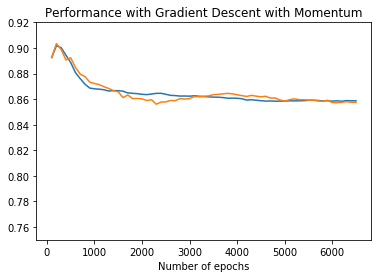

In [22]:
iterations = (np.arange(6500//100) +1)*100
plt.plot(iterations, performance_train, label= "Training scores")
plt.plot(iterations, performance_test, label = "Testing scores")
plt.title("Performance with Gradient Descent with Momentum")
plt.xlabel("Number of epochs")
plt.ylim([0.75, 0.92])
plt.show()

In [23]:
#save weights so they can be used again without rerunningn every thing
np.savetxt("final_weightspart5.txt", final_weights)

In [94]:
performance_train, performance_test

(array([ 0.74053333,  0.77355   ,  0.79148333,  0.80391667,  0.81326667,
         0.82061667,  0.82678333,  0.83255   ,  0.83705   ,  0.84065   ,
         0.84363333,  0.84698333,  0.84946667,  0.8518    ,  0.85411667,
         0.85611667,  0.85798333,  0.85996667,  0.86153333,  0.86305   ,
         0.86405   ,  0.86535   ,  0.86645   ,  0.86745   ,  0.86836667,
         0.8692    ,  0.87003333,  0.87096667,  0.87171667,  0.8725    ,
         0.87335   ,  0.87423333,  0.87513333,  0.87593333,  0.87665   ,
         0.87718333,  0.87761667,  0.87818333,  0.87875   ,  0.87938333,
         0.8799    ,  0.88076667,  0.88121667,  0.88163333,  0.88213333,
         0.88275   ,  0.88301667,  0.88343333,  0.88376667,  0.88423333,
         0.8846    ,  0.88503333,  0.88525   ,  0.88556667,  0.886     ,
         0.88623333,  0.88663333,  0.88693333,  0.8873    ,  0.88751667,
         0.88783333,  0.88831667,  0.88861667,  0.88883333,  0.88906667,  0.        ]),
 array([ 0.7402,  0.7791,  0.7968,  

In [95]:
iterations =  np.arange(6500//100 )*100
iterations

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400])

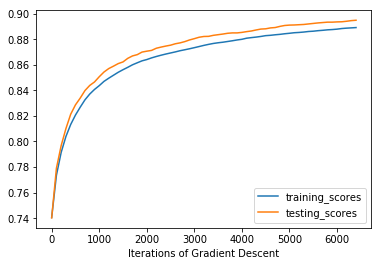

In [96]:
plt.plot(iterations, performance_train[:-1], label = "training_scores")
plt.plot(iterations, performance_test[:-1], label = "testing_scores")
plt.xlabel("Iterations of Gradient Descent")
plt.legend()
plt.show()

In [ ]:
#part 5, gradient descent with momentum